<a href="https://colab.research.google.com/github/Kenton-Tang-HK/Portfolio_Optimization/blob/main/PortfolioOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

Create a Portfolio

In [2]:
# Define a list of stock symbols you want to include in the portfolio
stock_symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

# Define the date range for historical data
start_date = '2018-01-01'
end_date = '2022-12-31'

# Fetch historical data for the selected stocks
portfolio_data = yf.download(stock_symbols, start=start_date, end=end_date)['Adj Close']

# Calculate daily returns
daily_returns = portfolio_data.pct_change().dropna()

# Fetch the 10-year Treasury yield as the risk-free rate (^IRX)
risk_free_data = yf.download('^IRX', start=start_date, end=end_date)['Adj Close']
risk_free_rate = risk_free_data.mean() / 100.0  # Convert to decimal

# Calculate mean returns and covariance matrix
mean_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  1 of 1 completed


Maximise Sharpe Ratio

Optimized Portfolio Weights:
AAPL: 0.3432
MSFT: 0.0000
GOOGL: 0.0000
AMZN: 0.3591
TSLA: 0.2977

Optimized Portfolio Sharpe Ratio: 0.9913594625407077


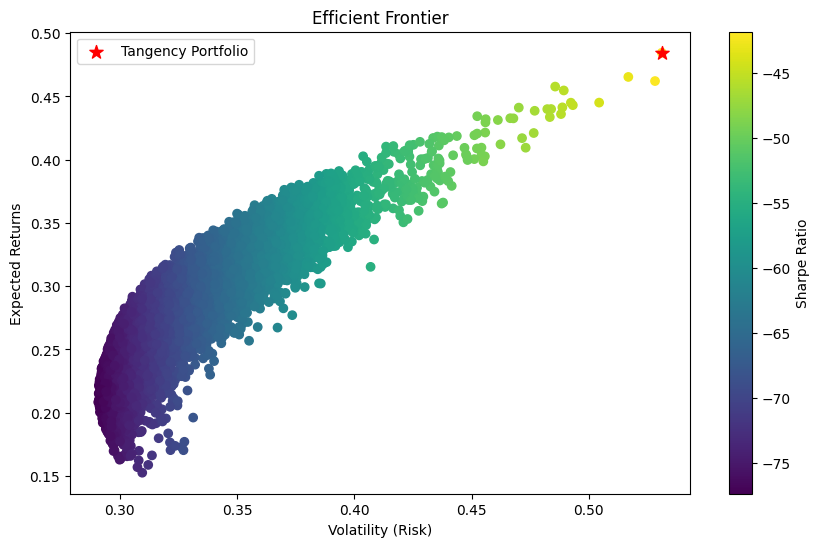

In [3]:
# Define the objective function for the Sharpe Ratio
def sharpe_ratio(weights):
    port_returns = np.sum(weights * mean_returns) * 252
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    sharpe = (port_returns - risk_free_rate) / port_volatility
    return -sharpe  # Minimize the negative Sharpe Ratio to maximize Sharpe Ratio

# Define constraints (e.g., sum of weights must be 1)
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Define bounds for the weights (between 0 and 1)
bounds = tuple((0, 1) for asset in range(len(stock_symbols)))

# Initial guess for weights (equal allocation)
initial_weights = len(stock_symbols) * [1.0 / len(stock_symbols)]

# Perform portfolio optimization to maximize the Sharpe Ratio
optimized_weights = minimize(sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Display optimized portfolio weights
print("Optimized Portfolio Weights:")
for i, symbol in enumerate(stock_symbols):
    print(f"{symbol}: {optimized_weights.x[i]:.4f}")

# Calculate and display the Sharpe Ratio of the optimized portfolio
optimal_portfolio_sharpe_ratio = -optimized_weights.fun  # Invert the negative value
print("\nOptimized Portfolio Sharpe Ratio:", optimal_portfolio_sharpe_ratio)

# Calculate and visualize the efficient frontier
num_portfolios = 10000
results = np.zeros((4, num_portfolios))
risk_free_rate_annual = (1 + risk_free_rate) ** 252 - 1

for i in range(num_portfolios):
    weights = np.random.random(len(stock_symbols))
    weights /= np.sum(weights)
    port_returns = np.sum(weights * mean_returns) * 252
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    results[0, i] = port_returns
    results[1, i] = port_volatility
    results[2, i] = (port_returns - risk_free_rate_annual) / port_volatility
    results[3, i] = np.random.randint(0, 100)

# Create a DataFrame to store portfolio data
columns = ['Returns', 'Volatility', 'Sharpe Ratio', 'Portfolio']
df = pd.DataFrame(results.T, columns=columns)

# Find the portfolio with the highest Sharpe Ratio (the "tangency portfolio")
tangency_portfolio = df.iloc[df['Sharpe Ratio'].idxmax()]

# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(df['Volatility'], df['Returns'], c=df['Sharpe Ratio'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.scatter(tangency_portfolio['Volatility'], tangency_portfolio['Returns'], c='red', marker='*', s=100, label='Tangency Portfolio')
plt.legend()
plt.show()


Mean-Variance Optimal Portfolios

Optimized Portfolio Weights:
AAPL: 0.2142
MSFT: 0.1286
GOOGL: 0.3568
AMZN: 0.3003
TSLA: 0.0000

Optimized Portfolio Volatility (Risk): 0.2906623876241003


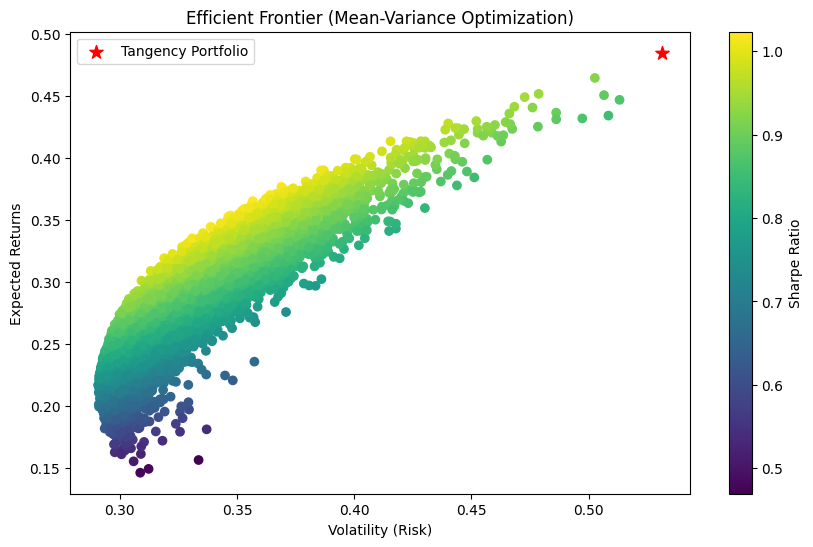

In [4]:
# Define the objective function for Mean-Variance Optimization
def portfolio_volatility(weights):
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return port_volatility

# Define constraints (e.g., sum of weights must be 1)
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Define bounds for the weights (between 0 and 1)
bounds = tuple((0, 1) for asset in range(len(stock_symbols)))

# Initial guess for weights (equal allocation)
initial_weights = len(stock_symbols) * [1.0 / len(stock_symbols)]

# Perform Mean-Variance Portfolio Optimization
optimized_weights = minimize(portfolio_volatility, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Display optimized portfolio weights
print("Optimized Portfolio Weights:")
for i, symbol in enumerate(stock_symbols):
    print(f"{symbol}: {optimized_weights.x[i]:.4f}")

# Calculate and display the volatility of the optimized portfolio
optimal_portfolio_volatility = portfolio_volatility(optimized_weights.x)
print("\nOptimized Portfolio Volatility (Risk):", optimal_portfolio_volatility)

# Calculate and visualize the efficient frontier for Mean-Variance Optimization
num_portfolios = 10000
results = np.zeros((2, num_portfolios))

for i in range(num_portfolios):
    weights = np.random.random(len(stock_symbols))
    weights /= np.sum(weights)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    port_return = np.sum(weights * mean_returns) * 252
    results[0, i] = port_volatility
    results[1, i] = port_return

# Create a DataFrame to store portfolio data
columns = ['Volatility', 'Returns']
df = pd.DataFrame(results.T, columns=columns)

# Plot the efficient frontier for Mean-Variance Optimization
plt.figure(figsize=(10, 6))
plt.scatter(df['Volatility'], df['Returns'], c=df['Returns'] / df['Volatility'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier (Mean-Variance Optimization)')

# Label the tangency portfolio
plt.scatter(tangency_portfolio['Volatility'], tangency_portfolio['Returns'], c='red', marker='*', s=100, label='Tangency Portfolio')

plt.legend()
plt.show()